<a href="https://colab.research.google.com/github/Bhuvan-Arora-1313/Fruits-classification-using-CNN/blob/main/Fruits_cassification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uploading kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhuvanarora1313","key":"3cf0a126714ced310f2d752675f636a7"}'}

In [ ]:
# Placing kaggle.json in correct directory
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
#Downloading the fruits dataset from kaggle
!kaggle datasets download -d moltean/fruits

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
fruits.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Unzip it
import zipfile
with zipfile.ZipFile("fruits.zip", 'r') as zip_ref:
    zip_ref.extractall("fruit_dataset")

#imports

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [ ]:
BATCHSIZE = 32
IMGE_SIZE = (224,224)

In [ ]:
train_dir = '/content/fruit_dataset/fruits-360_original-size/fruits-360-original-size/Training'
pred_dir = '/content/fruit_dataset/fruits-360_original-size/fruits-360-original-size/Validation'
test_dir = '/content/fruit_dataset/fruits-360_original-size/fruits-360-original-size/Test'

In [ ]:
filepaths_train= []
label_train = []
folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir,fold)
    files = os.listdir(foldpath)
    for file in tqdm(files):
        filepath = os.path.join(foldpath,file)
        filepaths_train.append(filepath)
        label_train.append(fold)

100%|██████████| 458/458 [00:00<00:00, 523859.08it/s]


In [ ]:
len(filepaths_train)

29222

In [ ]:
df_train = pd.DataFrame(
    {
        'filepath_train': filepaths_train,
        'label_train': label_train
    }
)
filepaths_test= []
label_test = []
folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir,fold)
    files = os.listdir(foldpath)
    for file in tqdm(files):
        filepath = os.path.join(foldpath,file)
        filepaths_test.append(filepath)
        label_test.append(fold)

df_test = pd.DataFrame(
    {
        'filepath_test': filepaths_test,
        'label_test': label_test
    }
)


100%|██████████| 228/228 [00:00<00:00, 515804.38it/s]


In [ ]:
df_train.head(100)

,filepath_train,label_train
0,/content/fruit_dataset/fruits-360_original-siz...,apple_crimson_snow_1
1,/content/fruit_dataset/fruits-360_original-siz...,apple_crimson_snow_1
2,/content/fruit_dataset/fruits-360_original-siz...,apple_crimson_snow_1
3,/content/fruit_dataset/fruits-360_original-siz...,apple_crimson_snow_1
4,/content/fruit_dataset/fruits-360_original-siz...,apple_crimson_snow_1
...,...,...
95,/content/fruit_dataset/fruits-360_original-siz...,apple_crimson_snow_1
96,/content/fruit_dataset/fruits-360_original-siz...,apple_crimson_snow_1
97,/content/fruit_dataset/fruits-360_original-siz...,apple_crimson_snow_1
98,/content/fruit_dataset/fruits-360_original-siz...,apple_crimson_snow_1


#Data Distribution Visualization

In [ ]:
color = ['#FFE1FF','#E4B1F0','#7E60BF','#433878']

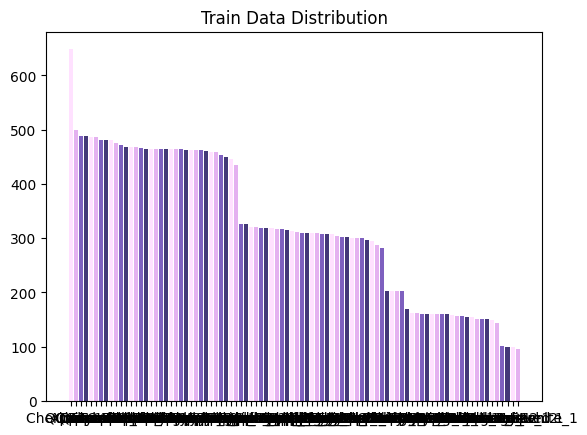

In [ ]:
plt.bar(df_train['label_train'].value_counts().index,df_train['label_train'].value_counts(),color=color)
plt.title('Train Data Distribution')
plt.show()

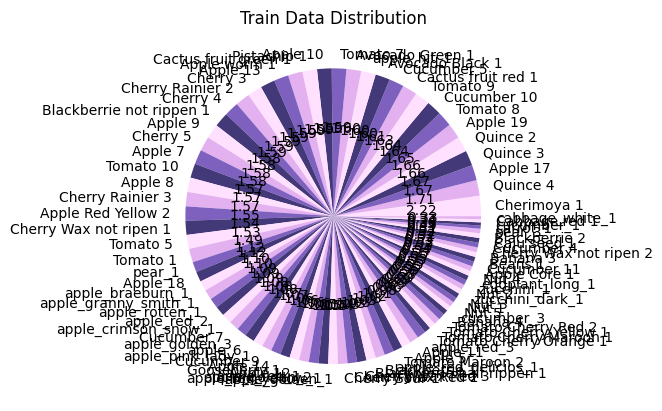

In [ ]:
plt.pie(df_train['label_train'].value_counts(),labels=df_train['label_train'].value_counts().index,colors=color,autopct='%.2f')
plt.title('Train Data Distribution')
plt.show()

#Data Information

In [ ]:
print(f'this data has {df_train.shape[0]} rows and {df_train.shape[1]} columns')

this data has 29222 rows and 2 columns


#ImageDataGenerator Setup

In [ ]:
data_gen = ImageDataGenerator(
    rescale=1./255,
)


data_test_gen = ImageDataGenerator(rescale=1./255)





In [ ]:
train_gen = data_gen.flow_from_dataframe(
    df_train,
    x_col='filepath_train',
    y_col='label_train',
    target_size=(IMGE_SIZE[0],IMGE_SIZE[1]),
    class_mode='categorical',
    shuffle=True,
    batch_size=BATCHSIZE,
)

valid_gen = data_gen.flow_from_dataframe(
    df_test,
    x_col='filepath_test',
    y_col='label_test',
    target_size=(IMGE_SIZE[0],IMGE_SIZE[1]),
    class_mode='categorical',
    shuffle=False,
    batch_size=BATCHSIZE,
)

test_gen = data_test_gen.flow_from_dataframe(
    df_test,
    x_col='filepath_test',
    y_col='label_test',
    target_size=(IMGE_SIZE[0],IMGE_SIZE[1]),
    class_mode='categorical',
    shuffle=False,
    batch_size=BATCHSIZE
)

Found 29222 validated image filenames belonging to 90 classes.
Found 14527 validated image filenames belonging to 90 classes.
Found 14527 validated image filenames belonging to 90 classes.


In [ ]:
class_dict = train_gen.class_indices
class_dict

{'Apple 10': 0,
 'Apple 11': 1,
 'Apple 12': 2,
 'Apple 13': 3,
 'Apple 14': 4,
 'Apple 17': 5,
 'Apple 18': 6,
 'Apple 19': 7,
 'Apple 5': 8,
 'Apple 7': 9,
 'Apple 8': 10,
 'Apple 9': 11,
 'Apple Core 1': 12,
 'Apple Red Yellow 2': 13,
 'Apple worm 1': 14,
 'Avocado Black 1': 15,
 'Avocado Green 1': 16,
 'Banana 3': 17,
 'Banana 4': 18,
 'Beans 1': 19,
 'Blackberrie 1': 20,
 'Blackberrie 2': 21,
 'Blackberrie half rippen 1': 22,
 'Blackberrie not rippen 1': 23,
 'Cabbage red 1': 24,
 'Cactus fruit green 1': 25,
 'Cactus fruit red 1': 26,
 'Caju seed 1': 27,
 'Cherimoya 1': 28,
 'Cherry 3': 29,
 'Cherry 4': 30,
 'Cherry 5': 31,
 'Cherry Rainier 2': 32,
 'Cherry Rainier 3': 33,
 'Cherry Sour 1': 34,
 'Cherry Wax Red 2': 35,
 'Cherry Wax Red 3': 36,
 'Cherry Wax not ripen 1': 37,
 'Cherry Wax not ripen 2': 38,
 'Cucumber 10': 39,
 'Cucumber 11': 40,
 'Cucumber 4': 41,
 'Cucumber 5': 42,
 'Cucumber 7': 43,
 'Cucumber 9': 44,
 'Gooseberry 1': 45,
 'Nut 1': 46,
 'Nut 2': 47,
 'Nut 3': 48,


In [ ]:
for batch_imge, batch_label in train_gen:
    print(batch_imge.shape)
    print(batch_label.shape)
    break

(32, 224, 224, 3)
(32, 90)


ValueError: num must be an integer with 1 <= num <= 25, not 26

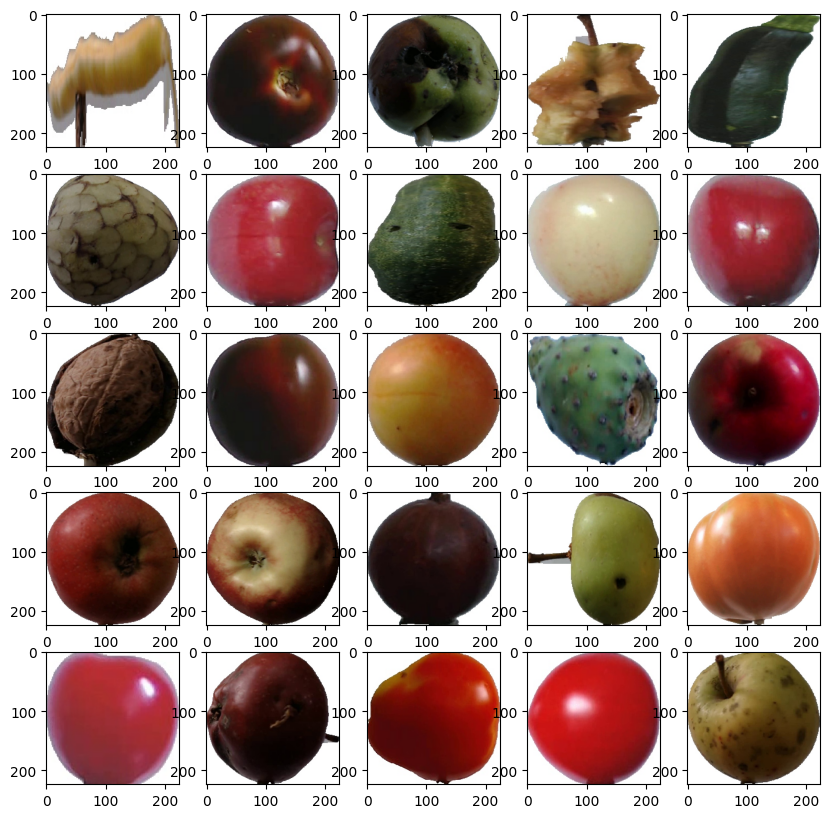

In [ ]:
for batch_imge, batch_label in train_gen:
    plt.figure(figsize=(10,10))
    for i in range(32):
        plt.subplot(5,5,i+1)
        plt.imshow(batch_imge[i])
        plt.axis('on')
    break

In [ ]:
Model = Sequential([
    Conv2D(64, kernel_size= (3,3),padding='same', activation='relu', input_shape=(IMGE_SIZE[0],IMGE_SIZE[1],3)),
    Conv2D(64, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),

    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),


    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),

    Conv2D(256, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(256, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),

    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),

    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(90, activation='softmax') ])

In [ ]:
Model.summary()

In [ ]:
Model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = Model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

In [ ]:
print(Model.evaluate(train_gen))
print(Model.evaluate(valid_gen))
print(Model.evaluate(test_gen))

In [ ]:
Model.save('Model_intel_ACC87.h5')

In [ ]:
preds = Model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
cm = confusion_matrix(valid_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(19,12))
sns.heatmap(cm, annot=True, fmt='d', cmap=color, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
def predict(img_path):


    label = list(class_dict.keys())
    plt.figure(figsize=(12, 19))
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = Model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

In [ ]:
predict('/content/fruit_dataset/fruits-360_original-size/fruits-360-original-size/Test/apple_red_delicios_1/r0_119.jpg')